# Quantum Walk on Line Topology

## Introduction to Quantum Walks

Quantum walks are the quantum analog of classical random walks. They play a crucial role in the development of quantum algorithms and have applications in various fields, including quantum computing, quantum information, and graph theory. Unlike classical walks, quantum walks leverage quantum superposition and interference, leading to potentially faster and more efficient algorithms.

## Objective:
Design the quantum walk operator for the case of a line with 16 nodes
For a line with 16 nodes, the nodes are labeled as $|0\rangle$,$|1\rangle$,$|2\rangle$,....,$|15\rangle$ . The quantum walk operator on a line involves moving left or right along the line, which can be represented by shift operators.

In a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. For example, consider a line of 16 nodes numbered from 0 to 15. In this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability.

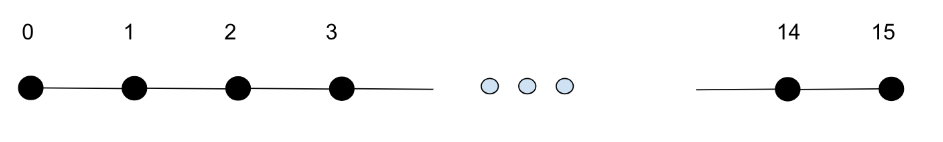

_Image credits: Womanium Quantum + AI Scholarip Program with Classiq on Canva_

Let's start by importing our required packages and setting the number of qubits as 4 ($log_2(16)$)

In [2]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [4]:
size = 4 # Number of qubits to represent the 16 vertices (log2 of 16 nodes)
num_nodes = 2**size # Total number of nodes (16 nodes)

The algorithm will include two major steps:
- Coin Operator: The coin operator for a quantum walk is typically the Hadamard operator, which creates a superposition of moving left or right.
- Shift Operator: The shift operators for a line with 16 nodes will include a left shift and a right shift

## Coin Operator
In a classical random walk, at each step, the walker decides which direction to move (left or right) based on the flip of a coin. The coin determines the probability of moving in each direction, typically resulting in a 50-50 chance.
In quantum walks, the decision-making process is governed by quantum mechanics, specifically by a quantum coin operator. The quantum coin operator creates a superposition of states, allowing the walker to be in multiple states simultaneously. This is a key feature that provides quantum walks with their unique propertiesp The coin operator in a quantum walk serves two main purposes:
1. Creating Superposition: It generates a superposition of possible directions (or states) the walker can take.
2. Ensuring Interference: It facilitates the interference between different paths, which can speed up certain computational processes.
One of the most commonly used coin operators is the Hadamard operator. The Hadamard operator is a single-qubit operation that transforms the basis states $|0\rangle$ and $|1\rangle$ into an equal superposition of these states.roIn a quantum walk on a line, the walker can move left or right at each step. The coin operator (often the Hadamard operator) is applied to create a superposition of these movementsrocess, we'll setup the probability based on above discussed idea. We, then, use diffuser oracle to to amplify the probabilities of adjacent nodes.

In [7]:
# Function to prepare a qubit in the |-> state
@qfunc
def prepare_minus(x: QBit):
    """
    Prepares a qubit in the |-> state.
    
    Args:
        x (QBit): The qubit to prepare.
    """
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    """
    Implements a diffuser oracle for Grover's algorithm.
    
    Args:
        aux (Output[QNum]): Auxiliary qubit.
        x (QNum): QNum representing the node to check.
    """
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    """
    Implements the zero diffuser for the quantum walk.
    
    Args:
        x (QNum): QNum representing the current node.
    """
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """
    Defines the coin operation for the quantum walk.
    
    Args:
        i (int): Current node index.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    prob = [0]*num_nodes  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the coin operator to all vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

## Shift Operator

The shift operator is a critical component of the quantum walk on a line. It is responsible for moving the quantum walker from one position to another based on the coin state. Let's delve into the details of the shift operator and its application in a quantum walk on a line. In a classical random walk on a line, at each step, the walker moves either to the left or to the right with equal probability. The direction is determined by a random coin flip. In a quantum walk, the movement is determined by the quantum coin state. The shift operator takes the superposition state generated by the coin operator and moves the walker accordingly.
For a line with 𝑛 nodes, the shift operators are defined to move the walker left or right based on the coin state.
1. Left Shift Operator: Moves the walker one step to the left if the coin state is $|0\rangle$.
2. Right Shift Operator: Moves the walker one step to the right if the coin state is $|1\rangle$.

These shift operators are represented as matrices that act on the position states of the walker.

In [8]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Oracle that checks if two vertices are adjacent.
    
    Args:
        res (Output[QBit]): Result bit to store the adjacency check.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """
    Swaps the values of two QArrays bit by bit.
    
    Args:
        x (QArray[QBit]): First QArray of qubits.
        y (QArray[QBit]): Second QArray of qubits.
    """
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the shift operator to swap vertices with their adjacent vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## Quantum Walk Function

The process begins by initializing the walker in a superposition of all possible positions along the line. The overall quantum walk operator applies the coin operator first to create a superposition.
Then, it applies the shift operators to move the walker according to the superposed states.
The shift operator in a quantum walk on a line is crucial for updating the position of the walker based on the coin state. This combination of coin and shift operations enables the unique quantum behavior of superposition and interference, which are fundamental to quantum walks.

In [9]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """
    Main function to perform the quantum random walk.
    
    Args:
        vertices (Output[QNum]): Output QNum to represent vertices.
        adjacent_vertices (Output[QNum]): Output QNum to represent adjacent vertices.
    """
    allocate(size, vertices)  # Allocate qubits for vertices
    hadamard_transform(vertices)  # Apply Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    C_operator(vertices, adjacent_vertices)  # Apply coin operator
    S_operator(vertices, adjacent_vertices)  # Apply shift operator

### Simulating Quantum Walk

In [11]:
# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

### Synthesized Circuit
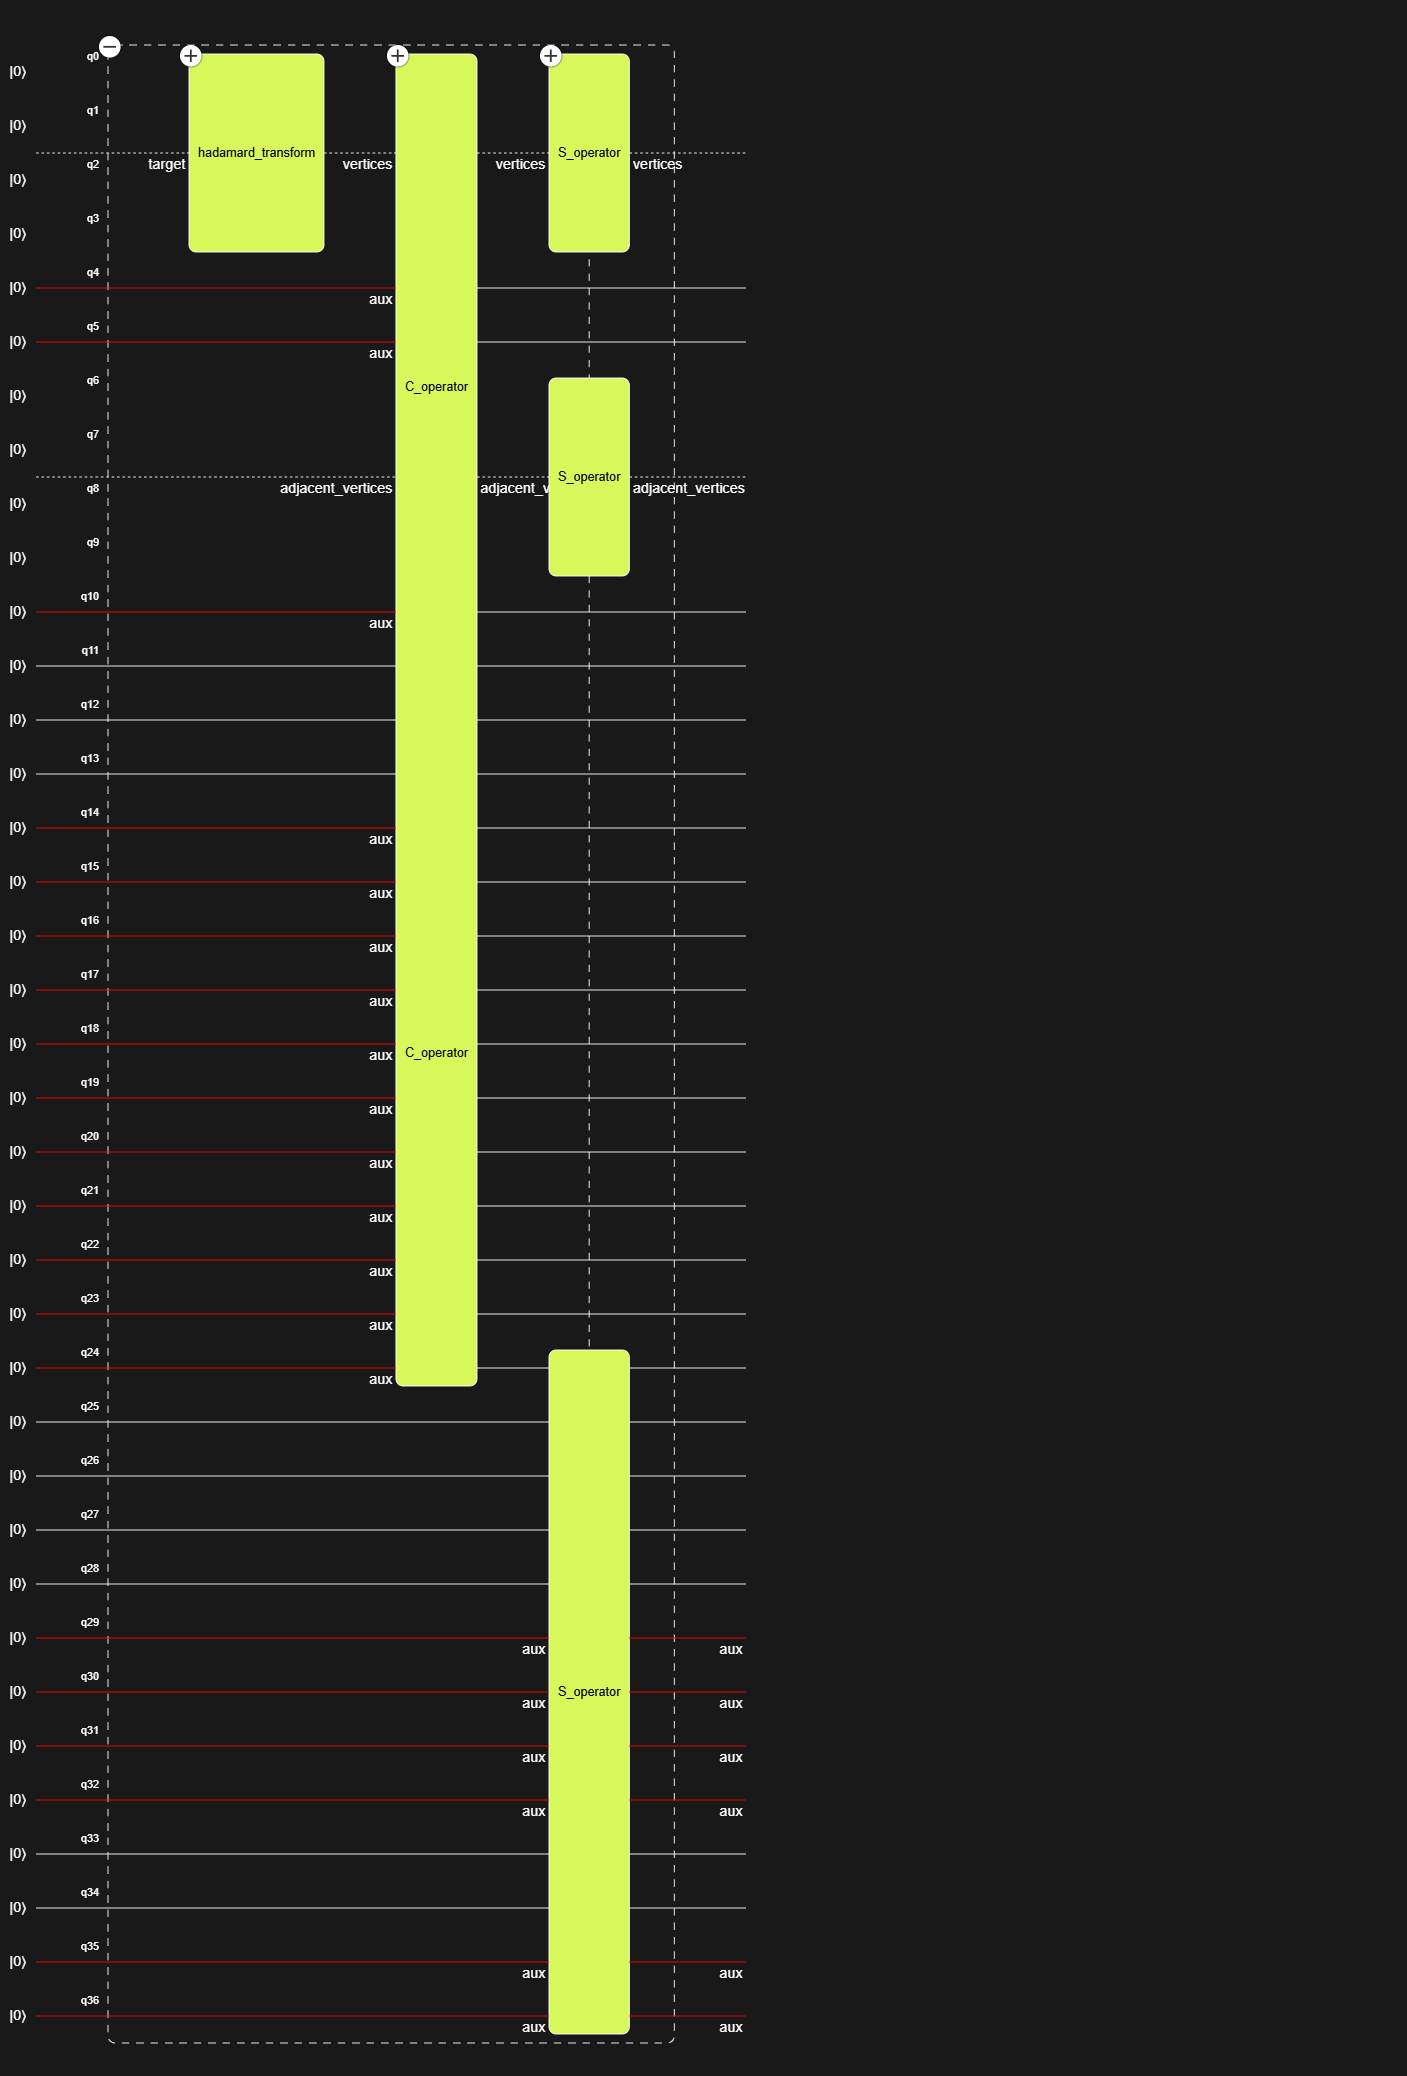

Zooming in the circuit we can observe that circuit implemented our desired algorithm correctly.

Since the circuit is ver wide, it's not possible to include it here. However, below are some screenshots to make understand how it works.

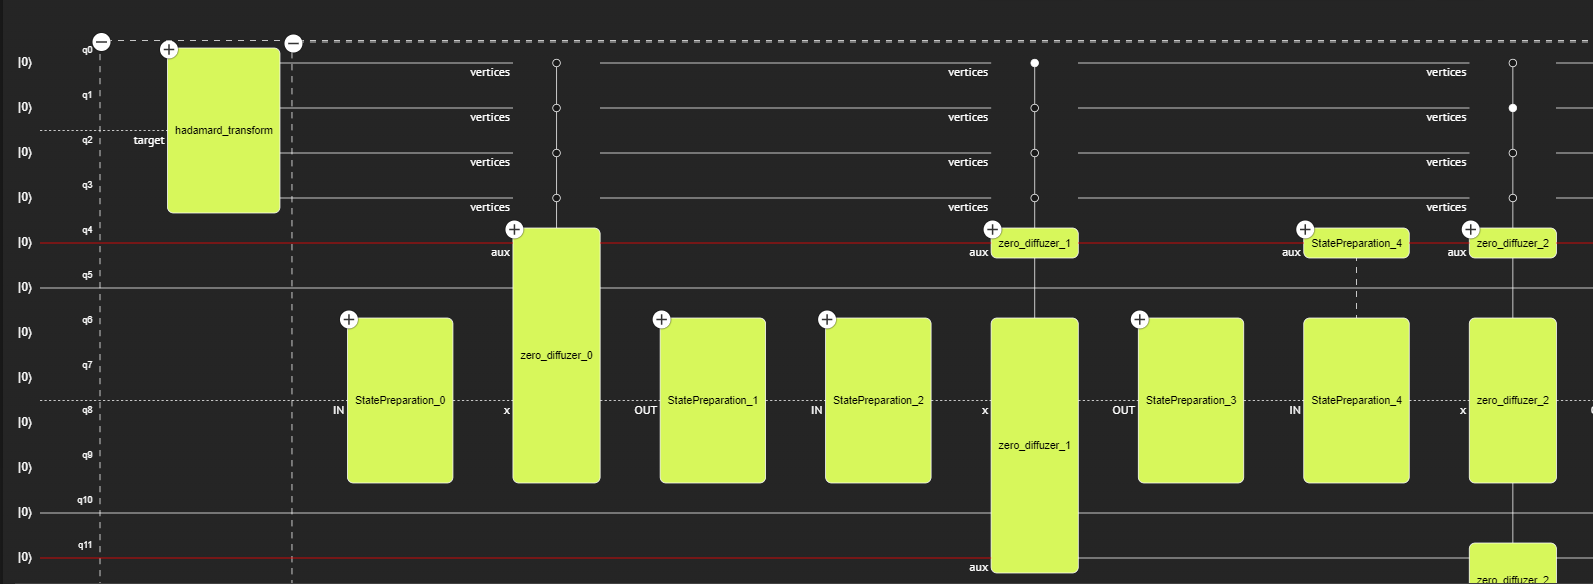

The screenshot depicts a segment of the quantum circuit corresponding to the Coin operator applied in the quantum random walk algorithm.

The circuit begins with the application of Hadamard gates to creates an equal superposition of all possible states (positions), allowing the walker to have a non-zero probability of being at any of the 16 nodes. State preparation block prepares the probabilities for moving to adjacent vertices. For each node, this function sets the probability amplitudes for the walker to move to its neighboring nodes. Zero diffuser blockapplies the diffusion operator to ensure that the probabilities are correctly distributed. The auxiliary qubit (aux) is used to facilitate this operation. The operations are applied sequentially to each node.

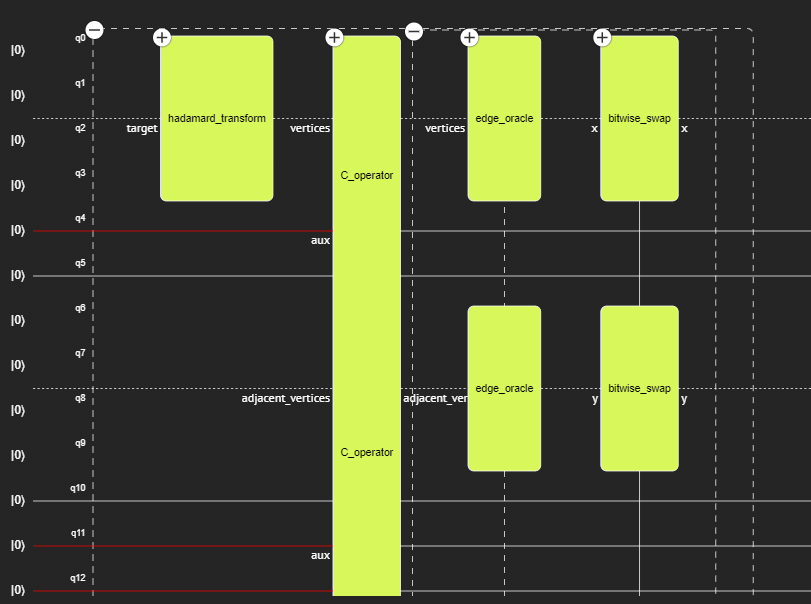

Here, it can be observed how Shift operator is being implemented.

Edge oracle block checks if the current vertex and an adjacent vertex are connected by an edge. If the vertices are adjacent, it sets a flag qubit to indicate this. If the edge oracle indicates adjacency, the bitwise swap operation swaps the states of the vertices and adjacent_vertices qubits. This swap simulates the walker's movement to the adjacent vertex. The dashed control lines indicate that the bitwise swap operation is conditional based on the adjacency check by the edge_oracle. This ensures that the swap only occurs if the vertices are indeed adjacent.